In [1]:
import numpy as np, os, sys
import pandas as pd
from scipy.io import loadmat
from scipy.signal import butter, lfilter
from scipy import stats

import heartpy as hp
import neurokit2 as nk

import matplotlib.pyplot as plt

from get_12ECG_features import get_12ECG_features_labels, detect_peaks

In [2]:
def process_signals(i, f, num_files, input_directory, df_raw):
    # print('    {}/{}...'.format(i+1, num_files))
    tmp_input_file = os.path.join(input_directory,f)
    data,header_data = load_challenge_data(tmp_input_file)
    
    features = get_HRVs_values(data, header_data)
    return features

In [3]:
def process_p_peaks(i, f, num_files, input_directory, df_raw):
    # print('    {}/{}...'.format(i+1, num_files))
    tmp_input_file = os.path.join(input_directory,f)
    data,header_data = load_challenge_data(tmp_input_file)
    
    features = get_pPeaks(data, header_data)
    return features

In [4]:
def load_challenge_data(filename):

    x = loadmat(filename)
    data = np.asarray(x['val'], dtype=np.float64)

    new_file = filename.replace('.mat','.hea')
    input_header_file = os.path.join(new_file)

    with open(input_header_file,'r') as f:
        header_data=f.readlines()


    return data, header_data

In [5]:
input_directory = '../Training_WFDB'

input_files = []
for f in os.listdir(input_directory):
    if os.path.isfile(os.path.join(input_directory, f)) and not f.lower().startswith('.') and f.lower().endswith('mat'):
        input_files.append(f)
        
df_raw = pd.DataFrame()
num_files = len(input_files)

In [6]:
def get_HRVs_values(data, header_data):

    filter_lowcut = 0.001
    filter_highcut = 15.0
    filter_order = 1

    tmp_hea = header_data[0].split(' ')
    ptID = tmp_hea[0]
    num_leads = int(tmp_hea[1])
    sample_Fs= int(tmp_hea[2])
    gain_lead = np.zeros(num_leads)
    
    for ii in range(num_leads):
        tmp_hea = header_data[ii+1].split(' ')
        gain_lead[ii] = int(tmp_hea[2].split('/')[0])


    for iline in header_data:
        if iline.startswith('#Age'):
            tmp_age = iline.split(': ')[1].strip()
            age = int(tmp_age if tmp_age != 'NaN' else np.nan())
            age = int(tmp_age)
        elif iline.startswith('#Sex'):
            tmp_sex = iline.split(': ')[1]
            if tmp_sex.strip()=='Female':
                sex =1
            else:
                sex=0
        elif iline.startswith('#Dx'):
            label = iline.split(': ')[1].split(',')[0]
            #label = iline.split(': ')[1].split(',')

    signal = data[1]
    gain = gain_lead[1]

    ecg_signal = nk.ecg_clean(signal*gain, sampling_rate=sample_Fs, method="biosppy")
    _ , rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=sample_Fs)
    hrv_time = nk.hrv_time(rpeaks, sampling_rate=sample_Fs)
    
    
    peaks = rpeaks['ECG_R_Peaks']
    
    
    # print(label, age)
    print(f'Paciente {label} Edad {age}')
    print(f'Duracion de la muestra: {len(signal) / sample_Fs} s')
    
    plt.figure(figsize=(20,5))
    plt.scatter(peaks, signal[np.array(peaks)]*gain, color='r')
    plt.plot(signal*gain)
    plt.show()
    
    
    win = 2500  # 5 segundos => 5 * sample_Fs
    rr_median = np.array([])
    
    for i in range(0, len(peaks), 1):
        # Me paro en el primer peak y miro 5s hacia adelante y hacia atras
        rg = np.array(range(peaks[i] - win, peaks[i] + win, 1))
        rr = []
        
        # Recorro el vector de peaks
        for x in range(len(peaks)):
            # Me fijo si hay algun peak dentro del rango definido
            if peaks[x] in rg:
                # Si encuentro uno lo agrego
                rr.append(peaks[x])
        
        # Paso mi vector rr de samples a tiempo
        rr = np.array(rr) / (sample_Fs)
        rr_diff = np.diff(rr)
        
        # Calculo la mediana movil para los peaks detectados dentro de la ventana
        rr_window = pd.Series(rr_diff).rolling(len(rr_diff)).median()
        rr_median = np.append(rr_median, rr_window.dropna())
    
    print('Intervalos RR con filtro de mediana:')
    print(f'{rr_median} \n')
    # print(stats.tvar(np.diff(rr_median)))
    print(f'Varianza del vector RR filtrado: {stats.tvar(rr_median)}')
    
        
    hrv_time['age'] = age
    hrv_time['label'] = label
    
    return hrv_time

In [7]:
def get_pPeaks(data, header_data):

    filter_lowcut = 0.001
    filter_highcut = 15.0
    filter_order = 1

    tmp_hea = header_data[0].split(' ')
    ptID = tmp_hea[0]
    num_leads = int(tmp_hea[1])
    sample_Fs= int(tmp_hea[2])
    gain_lead = np.zeros(num_leads)
    
    for ii in range(num_leads):
        tmp_hea = header_data[ii+1].split(' ')
        gain_lead[ii] = int(tmp_hea[2].split('/')[0])


    for iline in header_data:
        if iline.startswith('#Age'):
            tmp_age = iline.split(': ')[1].strip()
            age = int(tmp_age if tmp_age != 'NaN' else np.nan())
            age = int(tmp_age)
        elif iline.startswith('#Sex'):
            tmp_sex = iline.split(': ')[1]
            if tmp_sex.strip()=='Female':
                sex =1
            else:
                sex=0
        elif iline.startswith('#Dx'):
            label = iline.split(': ')[1].split(',')[0]
            #label = iline.split(': ')[1].split(',')

    signal = data[1]
    gain = gain_lead[1]

    ecg_signal = nk.ecg_clean(signal*gain, sampling_rate=sample_Fs, method="biosppy")
    _ , rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=sample_Fs)
    
    try:
        signal_peak, waves_peak = nk.ecg_delineate(ecg_signal, rpeaks, sampling_rate=sample_Fs)
        p_peaks = waves_peak['ECG_P_Peaks']
    except ValueError:
        print('Exception raised!')
        pass
    
    print(f'Paciente {label} Edad {age}')
    print(f'Duracion de la muestra: {len(signal) / sample_Fs} s')
    
    plt.figure(figsize=(20,5))
    plt.scatter(p_peaks, signal[np.array(p_peaks)]*gain, color='r')
    plt.plot(signal*gain)
    plt.show()

Paciente PAC
 Edad 64
Duracion de la muestra: 10.0 s


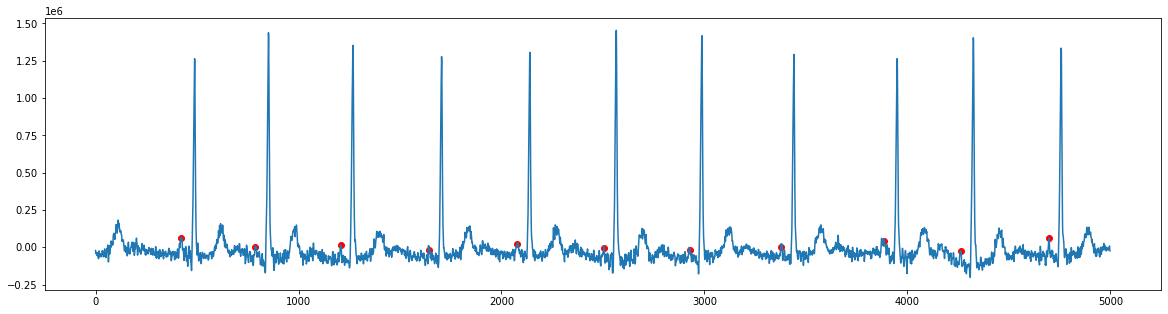



Paciente Normal
 Edad 24
Duracion de la muestra: 20.0 s


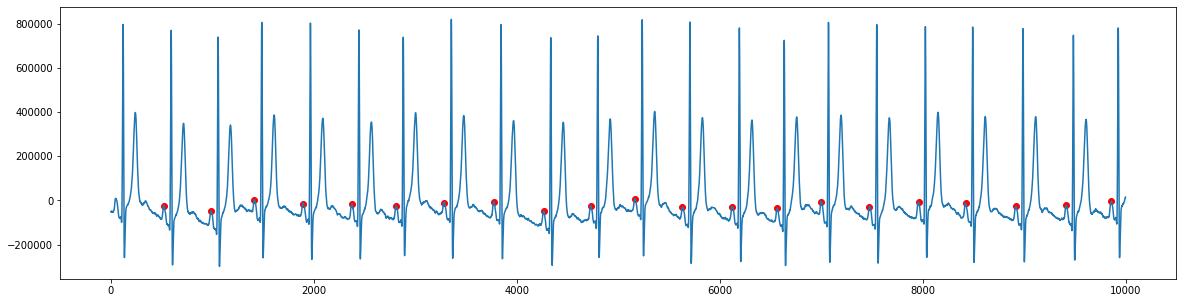



Paciente PAC
 Edad 59
Duracion de la muestra: 14.224 s


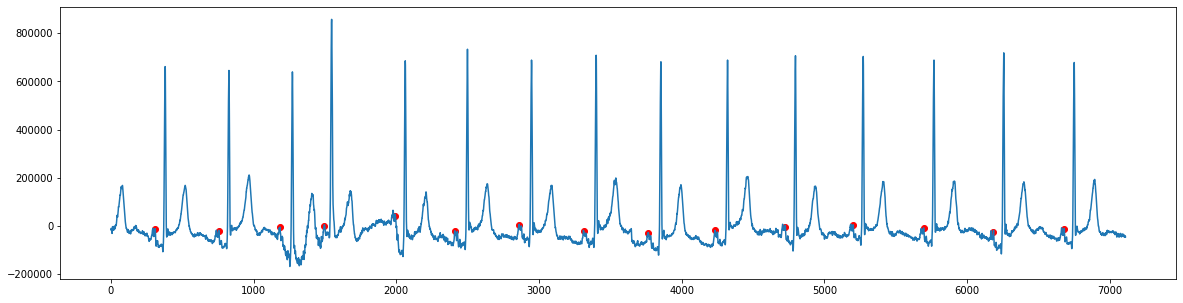



Paciente Normal
 Edad 14
Duracion de la muestra: 14.0 s


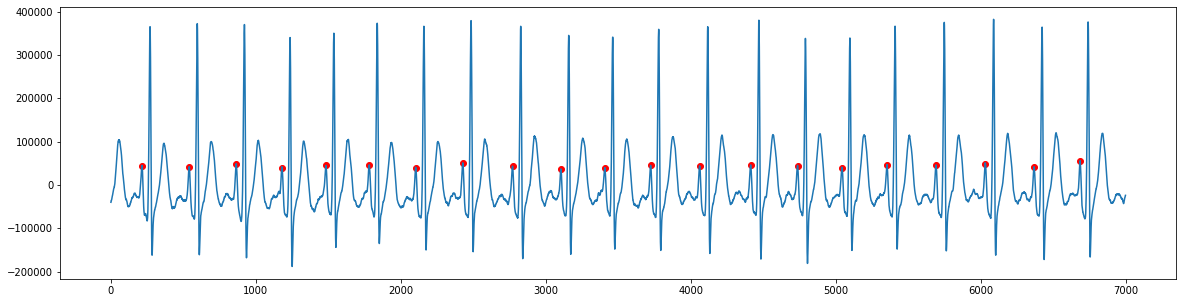



Paciente RBBB
 Edad 40
Duracion de la muestra: 11.0 s


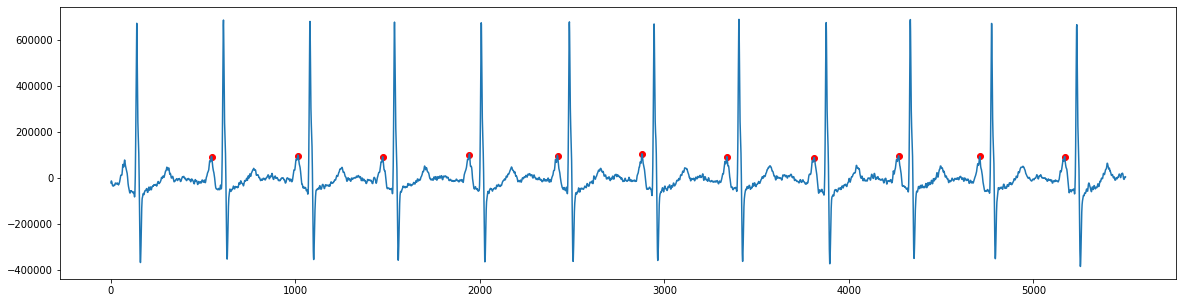



Paciente I-AVB
 Edad 64
Duracion de la muestra: 19.0 s


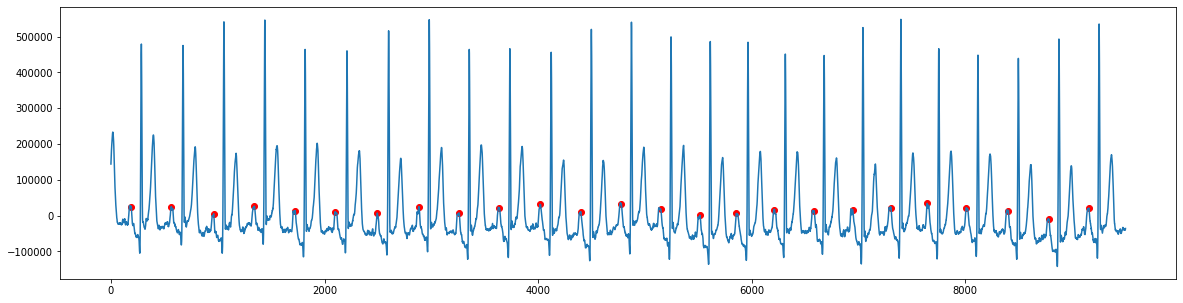



Paciente AF
 Edad 56
Duracion de la muestra: 10.0 s


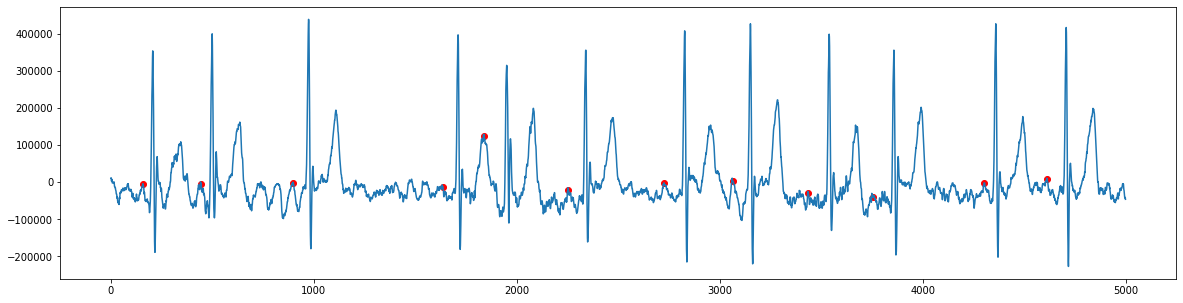



Paciente AF Edad 76
Duracion de la muestra: 10.0 s


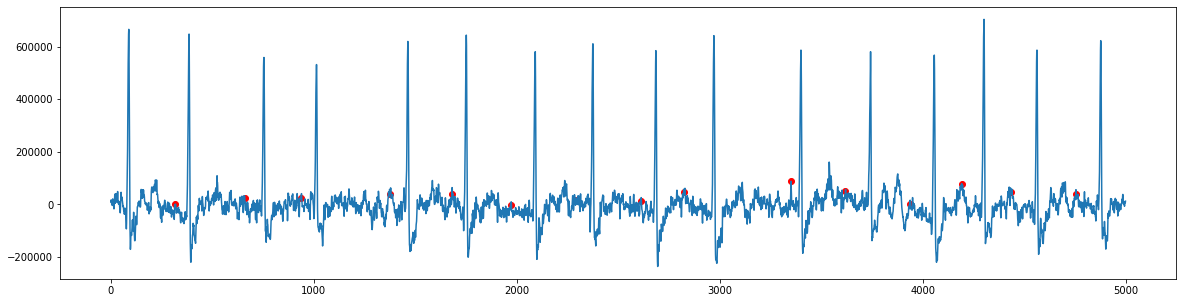



Paciente RBBB Edad 89
Duracion de la muestra: 10.0 s


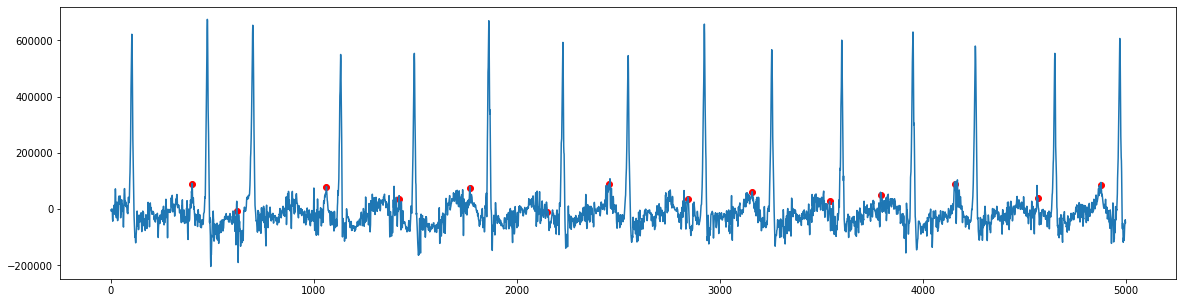



Paciente PVC
 Edad 42
Duracion de la muestra: 10.0 s


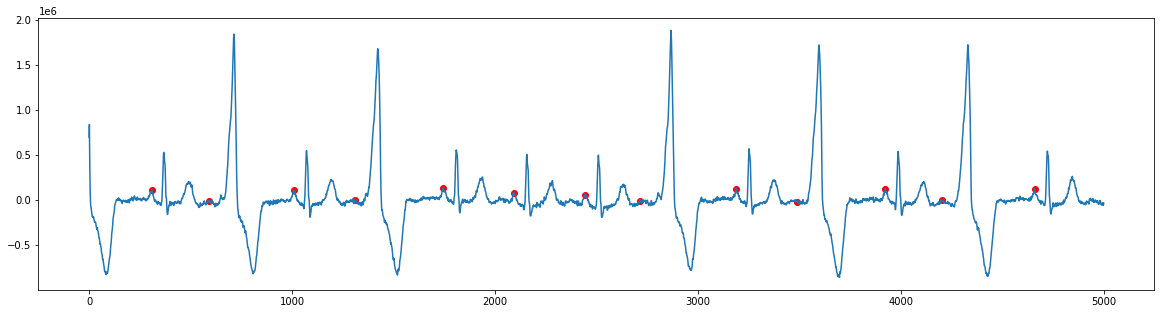



Paciente AF
 Edad 80
Duracion de la muestra: 14.0 s


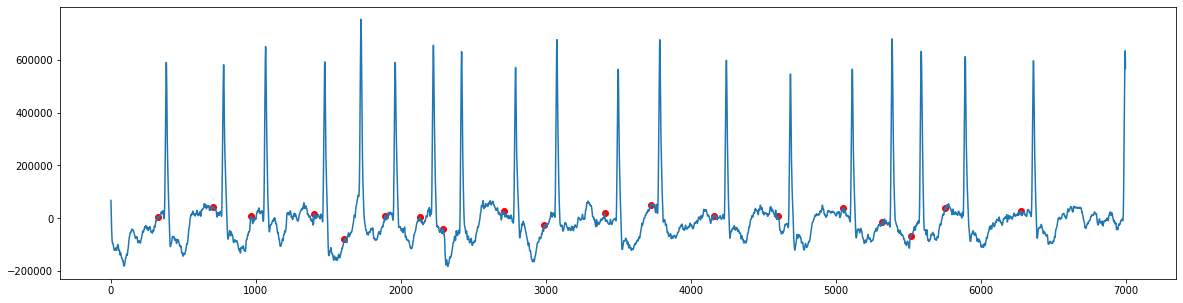



Paciente PVC
 Edad 62
Duracion de la muestra: 32.436 s


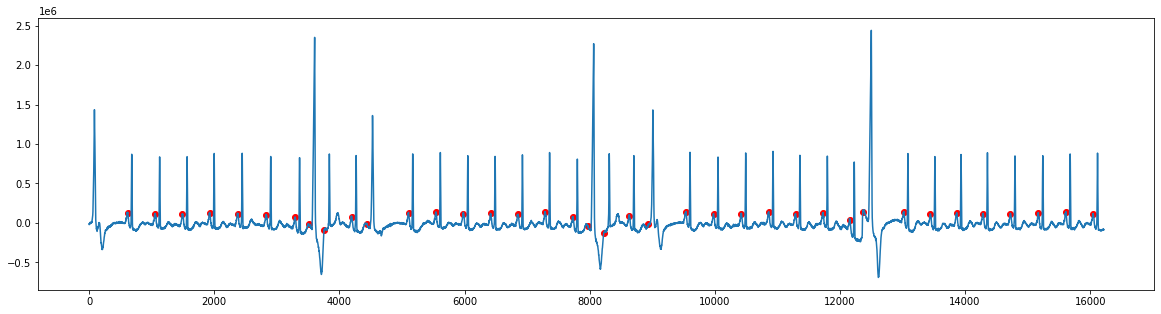



Paciente LBBB
 Edad 76
Duracion de la muestra: 10.0 s


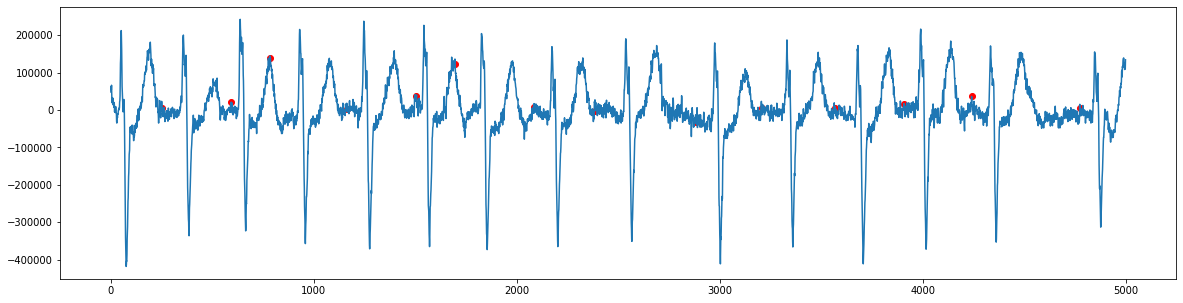



Paciente RBBB
 Edad 76
Duracion de la muestra: 15.0 s


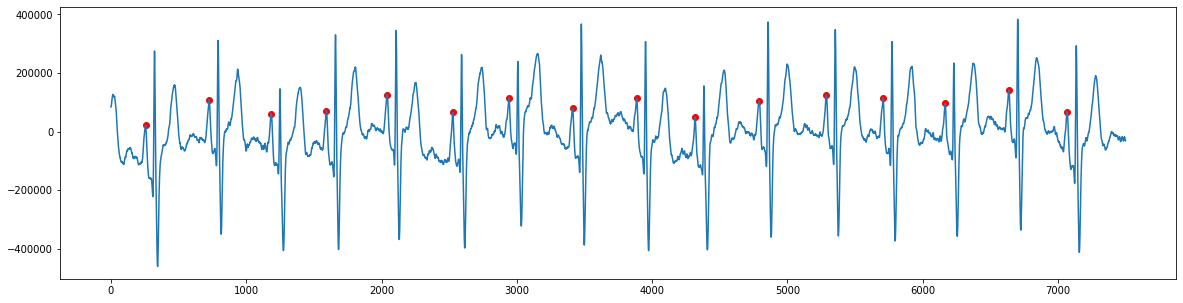



Paciente I-AVB
 Edad 81
Duracion de la muestra: 10.0 s


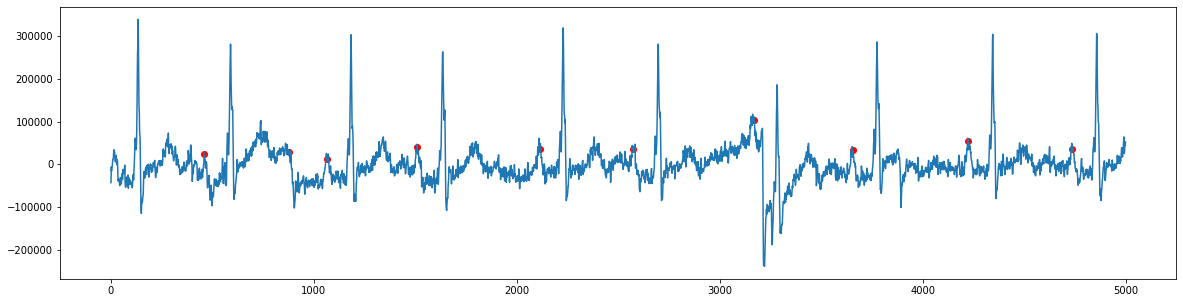

In [8]:
for i, f in enumerate(input_files[:15]):
    process_p_peaks(i, f, num_files, input_directory, df_raw)
    print('\n')